In [ ]:
import os, time
import numpy as np
import pickle

# RNN model and task
from model import RNN, run_net
from task_generators import flipflop, mante, romo

# Figures 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import style
from fig_specs import *
save_fig = True

# Data directory
from data_dir import data_dir

# Data files
tasks_mame = ["flipflop", "mante", "romo"]
tasks_data_file_name = [task_name + "_gs_adam_N_1024_lr0_005" for task_name in tasks_name]

In [ ]:
# Explain tasks
# xlim
x0f = 0.05
x1f = 1.55
# Batch for explain_task
batch_idx = 0
# Colors
cs_expl = colors
cs_expl = ["0.6", "0.1"]

def plot_flipflop_explain(fig, axes, task_explain, task_params, xlbl_on=True):
    ts_plt, u, y, mask, z = task_explain
    dim_in = u.shape[-1]
    dim_out = z.shape[-1]
    ax0, ax1, ax2 = axes
    
    # Task parameters
    t_max = task_params["t_max"]
    fixation_duration = task_params["fixation_duration"]
    stimulus_duration = task_params["stimulus_duration"]
    decision_delay_duration = task_params["decision_delay_duration"]
    stim_delay_duration_min = task_params["stim_delay_duration_min"]
    stim_delay_duration_max = task_params["stim_delay_duration_max"]
    input_amp = task_params["input_amp"]
    target_amp = task_params["target_amp"]
    fixate = task_params["fixate"]

    for i in range(dim_out):
        # Input
        ax0.plot(ts_plt, u[batch_idx, :, i], '-', lw=lw, c=cs_expl[i], label="$u_%d$" % (i+1))
        #) Output
        ax = [ax1, ax2][i]
        ax.plot(ts_plt, z[batch_idx, :, i], '-', lw=lw, c=cs_expl[0], label="$z_%d$" % (i+1))
        # Target
        m = np.bool_(mask[batch_idx, :, i])
        z_hat = y[batch_idx, :, i]
        z_hat = np.where(m, z_hat, np.nan)
        ax.plot(ts_plt, z_hat, '-', lw=lw, c=cs_expl[1], label="$\hat{z}_%d$" % (i+1))
    
#     # Indicate pulse times
#     pulses = (u[batch_idx, :].sum(axis=-1))
#     mask_pulses = (pulses[:-1] == 0) * (pulses[1:] != 0)
#     t_pulses = ts_plt[1:][mask_pulses]
#     for ti in t_pulses:
#         for ax in axes:
#             ax.axvline(ti, ls='--', lw=1, c='0.7', zorder=-1)
        
    ax0.set_yticks([-1., 0, 1.])
    ax0.set_ylabel("In")
    ax1.set_ylabel("Out 1")
    ax2.set_ylabel("Out 2")
    if xlbl_on:
        ax2.set_xlabel("Trial time $t$")#, labelpad=15)

    dt = ts_plt[1] - ts_plt[0]
    t_max_plt = ts_plt[-1] + dt
    x0 = -t_max_plt * x0f
    x1a = t_max_plt * (1 + x0f)
    x1b = t_max_plt * x1f

    for i, ax in enumerate(axes):
        ax.set_yticklabels([])
        ax.plot([x0, x1a], [0, 0], '-', c='0.7', zorder=-1)
        ax.set_xlim(x0, x1b)
        ax.legend(loc=1, frameon=False, framealpha=1., labelspacing=0.1, handlelength=1.)
        if not i == 2:
            ax.set_xticklabels([])
    ax2.set_xticks([0, t_max_plt//2, t_max_plt])

def plot_mante_explain(fig, axes, task_explain, task_params, xlbl_on=True):
    ax0, ax1, ax2 = axes
    ts_plt, u, y, mask, z = task_explain
    dim_in = u.shape[-1]
    dim_out = z.shape[-1]
    dim_sens = dim_in // 2
    
    # Task parameters
    choices = task_params["choices"]
    fixation_duration = task_params["fixation_duration"]
    stimulus_duration = task_params["stimulus_duration"]
    delay_duration = task_params["delay_duration"]
    decision_duration = task_params["decision_duration"]
    input_amp = task_params["input_amp"]
    context_amp = task_params["context_amp"]
    rel_input_std = task_params["rel_input_std"]
    target_amp = task_params["target_amp"]
    coherences = task_params["coherences"]
    fixate = task_params["fixate"]
    
    for i in range(dim_sens):
        # Sensory input
        ax0.plot(ts_plt, u[batch_idx, :, dim_sens + i], '-', lw=lw, c=cs_expl[i], label="$u_%d$" % (i+1))
        # Context
        ax1.plot(ts_plt, u[batch_idx, :, i], '-', lw=lw, c=cs_expl[i], label="$c_%d$" % (i+1))
    for i in range(dim_out):
        # Output
        ax2.plot(ts_plt, z[batch_idx, :, i], '-', lw=lw, c=cs_expl[0], label="$z$")
        # Target
        m = np.bool_(mask[batch_idx, :, i])
        z_hat = y[batch_idx, :, i]
        z_hat = np.where(m, z_hat, np.nan)
        ax2.plot(ts_plt, z_hat, '-', lw=lw, c=cs_expl[1], label="$\hat{z}$")
            
    # Indicate task phases
    t0 = fixation_duration
    t1 = t0 + stimulus_duration
    t2 = t1 + delay_duration
    t3 = t2 + decision_duration
    for i, ti in enumerate([t0, t1, t2]):
        for ax in axes:
            ax.axvline(ti, ls='--', lw=1, c='0.7', zorder=-1)

    ax1.set_yticks([0.0, 1.0])
    ax1.set_yticklabels([0.0, 1.0])
    ax2.set_ylim(-0.6, 0.6)
    ax2.set_yticks([-0.5, 0.])
        
    ax0.set_ylabel("Signal")
    ax1.set_ylabel("Context")
    ax2.set_ylabel("Out")
    if xlbl_on:
        ax2.set_xlabel("Trial time $t$")

#     y0, y1 = ax2.get_ylim()
#     ypos = y0 - 0.4 * (y1 - y0)
#     ax2.text((x0 + t0)/2, ypos, 'Fix', fontsize=fs, ha='center', va='bottom')
#     ax2.text((t0 + t1)/2, ypos, 'Input', fontsize=fs, ha='center', va='bottom')
#     ax2.text((t1 + t2)/2, ypos, 'Delay', fontsize=fs, ha='center', va='bottom')
#     ax2.text((t2 + t3)/2, ypos, 'Decision', fontsize=fs, ha='center', va='bottom')
#     ax2.set_xlabel("Trial time $t$", labelpad=15)
    
    dt = ts_plt[1] - ts_plt[0]
    t_max_plt = ts_plt[-1] + dt
    x0 = -t_max_plt * x0f
    x1a = t_max_plt * (1 + x0f)
    x1b = t_max_plt * x1f

    for i, ax in enumerate(axes):
        ax.set_yticklabels([])
        ax.plot([x0, x1a], [0, 0], '-', c='0.7', zorder=-1)
        ax.set_xlim(x0, x1b)
        ax.legend(loc=1, frameon=False, framealpha=1., labelspacing=0.1, handlelength=1.)
        if not i == 2:
            ax.set_xticklabels([])
#     ax2.set_xticks([0, t_max_plt//2, t_max_plt])
    ax2.set_xticks([0, 25, 50])

def plot_romo_explain(fig, axes, task_explain, task_params, xlbl_on=True):
    ax0, ax1, ax2 = axes
    ts_plt, u, y, mask, z = task_explain
    dim_in = u.shape[-1]
    dim_out = z.shape[-1]
    
    # Task parameters
    fixation_duration = task_params["fixation_duration"]
    stimulus_duration = task_params["stimulus_duration"]
    decision_delay_duration = task_params["decision_delay_duration"]
    decision_duration = task_params["decision_duration"]
    stim_delay_duration_min = task_params["stim_delay_duration_min"]
    stim_delay_duration_max = task_params["stim_delay_duration_max"]
    input_amp_min = task_params["input_amp_min"]
    input_amp_max = task_params["input_amp_max"]
    min_input_diff = task_params["min_input_diff"]
    target_amp = task_params["target_amp"]
    fixate = task_params["fixate"]

    # Input
    ax0.plot(ts_plt, u[batch_idx], '-', lw=lw, c=cs_expl[0], label="$u$")
    for i in range(dim_out):
        ax = [ax1, ax2][i]
        # Output
        ax.plot(ts_plt, z[batch_idx, :, i], '-', lw=lw, c=cs_expl[0], label="$z_%d$" % (i+1))
        # Target
        m = np.bool_(mask[batch_idx, :, i])
        z_hat = y[batch_idx, :, i]
        z_hat = np.where(m, z_hat, np.nan)
        ax.plot(ts_plt, z_hat, '-', lw=lw, c=cs_expl[1], label="$\hat{z}_%d$" % (i+1))

    # Indicate task phases
    stim_delay_duration = 0.5 * (stim_delay_duration_min + stim_delay_duration_max)
    t0 = fixation_duration
    t1 = t0 + stimulus_duration
    t2 = t1 + stim_delay_duration
    t3 = t2 + stimulus_duration
    t4 = t3 + decision_delay_duration
    t5 = t4 + decision_duration
    for i, ti in enumerate([t0, t1, t2, t3, t4, t5]):
        for ax in axes:
            ax.axvline(ti, ls='--', lw=1, c='0.7', zorder=-1)

    ax0.set_yticks([0.0, 1.0, 1.5])
    ax1.set_ylim(-0.6, 0.6)
    ax2.set_ylim(-0.6, 0.6)
    
    ax0.set_ylabel("In")
    ax1.set_ylabel("Out 1")
    ax2.set_ylabel("Out 2")
    if xlbl_on:
        ax2.set_xlabel("Trial time $t$")
    
#     y0, y1 = ax2.get_ylim()
#     ypos = y0 - 0.4 * (y1 - y0)
#     ax2.text((x0 + t0)/2, ypos, 'Fix', fontsize=fs, ha='center', va='bottom')
#     ax2.text((t0 + t1)/2, ypos, 's1', fontsize=fs, ha='center', va='bottom')
#     ax2.text((t1 + t2)/2, ypos, 'd1', fontsize=fs, ha='center', va='bottom')
#     ax2.text((t2 + t3)/2, ypos, 's2', fontsize=fs, ha='center', va='bottom')
#     ax2.text((t3 + t4)/2, ypos, 'd2', fontsize=fs, ha='center', va='bottom')
#     ax2.text((t4 + t5)/2, ypos, 'Decision', fontsize=fs, ha='center', va='bottom')
#     ax2.set_xlabel("Trial time $t$", labelpad=15)
    
    dt = ts_plt[1] - ts_plt[0]
    t_max_plt = ts_plt[-1] + dt
    x0 = -t_max_plt * x0f
    x1a = t_max_plt * (1 + x0f)
    x1b = t_max_plt * x1f

    for i, ax in enumerate(axes):
        ax.set_yticklabels([])
        ax.plot([x0, x1a], [0, 0], '-', c='0.7', zorder=-1)
        ax.set_xlim(x0, x1b)
        ax.legend(loc=1, frameon=False, framealpha=1., labelspacing=0.1, handlelength=1.)
        if not i == 2:
            ax.set_xticklabels([])
    ax2.set_xticks([0, 15, 30])

plot_tasks_explain = [plot_flipflop_explain, plot_mante_explain, plot_romo_explain]

In [ ]:
def plot_loss_over_training(fig, ax0, idx_sample, idxs_g, task_loss, legend=False, max_epoch=None, 
                            xlbl_on=True, ylbl_on=True, colors=colors, ylim=None):
    gs, epochs, losses_all, lr = task_loss
    n_epochs = len(epochs)
    n_plt_g = len(idxs_g)
    
    # Choose what to plot
    gs_plt = gs[idxs_g]
    losses_plt = losses_all[idx_sample, idxs_g]
    
    for i, idx_g in enumerate(idxs_g):
        g = gs_plt[i]
        c = colors[i]
        # Loss
        losses = losses_plt[i]
        ax0.plot(epochs, losses, '-', c=c, lw=lw, label="%.1f" % g)
        
    ax0.axhline(0, ls='-', c='0.7', zorder=-1)
    if max_epoch is None:
        max_epoch = n_epochs
    ax0.set_xlim(-max_epoch * 0.05, max_epoch * 1.05)
    ax0.set_xticks([0, max_epoch//2, max_epoch])
    
    loss_00 = losses_all[idx_sample, 0, 0]
    ax0.set_yticks([0, loss_00])
    ax0.set_yticklabels([0, "$L_0$"])
    if ylim is not None:
        ylim_a = loss_00 * ylim
        ax0.set_ylim(-0.05 * ylim_a, 1.05 * ylim_a)
    
    if xlbl_on:
        ax0.set_xlabel("Epoch")
    if ylbl_on:
        ax0.set_ylabel("Loss", labelpad=0)
    
    if legend:
        leg = ax0.legend(loc=1, ncol=1, 
                   title="$g$", title_fontsize=fs, 
                   labelspacing=0.03, handlelength=1.)
    # Move legend down/up
    leg_ax = ax0
    bb = leg.get_bbox_to_anchor().inverse_transformed(leg_ax.transAxes)
    xOffset = 0.
    bb.x0 += xOffset
    bb.x1 += xOffset
    yOffset = 0.15
    bb.y0 += yOffset
    bb.y1 += yOffset
    leg.set_bbox_to_anchor(bb, transform = leg_ax.transAxes)


def plot_sv_recon_loss(fig, axes, idx_sample, idxs_g, task_svs, legend=False, min_rank=1, max_rank=None, 
                       xlbl_on=True, ylbl_on=True, colors=colors, mask_off=False):
    gs, ranks, sv_dw_all, loss_rr_all = task_svs
    ax1, ax2 = axes
    n_plt_g = len(idxs_g)
    
    # Choose what to plot
    gs_plt = gs[idxs_g]
    loss_rr_plt = loss_rr_all[idx_sample, idxs_g]
    sv_dw_plt = sv_dw_all[idx_sample, idxs_g]
    
    # Max rank to show
    if max_rank is None:
        max_rank = ranks[-1]
        
    # Mask for minimal rank: plot only if the network converged...
    loss_0 = loss_rr_plt[:, 0]
    loss_c = rel_loss_c * loss_0
    idxs_c = np.argmax(loss_rr_plt < loss_c[:, None], axis=1)
    ranks_c = ranks[idxs_c]
    mask_mr = ranks_c > 0
    
    for i, idx_g in enumerate(idxs_g):
        if mask_mr[i] or mask_off:
            g = gs_plt[i]
            c = colors[i]
            # Reconstruction
            s_last = sv_dw_plt[i, -1]
            ax1.plot(ranks[1:max_rank+1], s_last[:max_rank], 'o-', c=c, lw=lw, label="%.1f" % g)
            loss_rr = loss_rr_plt[i]
            ax2.plot(ranks[min_rank:max_rank+1], loss_rr[min_rank:max_rank+1], 'o-', c=c, lw=lw, label="%.1f" % g)
        
    ax1.axhline(0, ls='-', c='0.7', zorder=-1)
    ax1.set_yticks([0, 1, 2])
    ax1.set_ylim(-0.15, 2.15)

    loss_00 = loss_rr_all[idx_sample, idxs_g[0], 0]
    ax2.set_yticks([0, loss_00])
#     ax2.set_ylim(-0.05 * loss_00, loss_00 * 1.6)
    ax2.set_yticklabels([0, "$L_0$"])
    ax2.axhline(0, ls='-', c='0.7', zorder=-1)
    
    if xlbl_on:
        ax2.set_xlabel("Rank")
    if ylbl_on:
#         ax1.set_ylabel("SV")
        ax1.set_ylabel("$SV(\Delta W)$")
        ax2.set_ylabel("Loss", labelpad=0)

    for ax in [ax1, ax2]:
        ax.set_xlim(min_rank - 0.5, max_rank + 0.5)
        ax.set_xticks([min_rank, (max_rank+1)//2, max_rank])
    ax1.set_xticklabels([])
    
    if legend:
        ax1.legend(loc=1, ncol=1, title="$g$", frameon=False, title_fontsize=fs, 
                   labelspacing=0.05, handlelength=1.)


# Training also IO weights

In [4]:
# Load data
tasks_name = ["flipflop", "mante", "romo"]
tasks_data_file_name = [fnp + "_gs_adam_train_wi_wrec_wo_N_256_lr0_005" for fnp in tasks_name]

# Results
tasks_lbl = ["Flip-flop", "Mante", "Romo"]
tasks_explain = []
tasks_params = []
tasks_loss = []
tasks_svs = []
tasks_ev = []
tasks_sv = []
tasks_loss_shuff = []
tasks_wio = []

# To plot trained network:
tasks_gen = [flipflop, mante, romo]
idx_sample = 0
idx_g = 4


for idx_task in range(3):
    # Load 
    data_file_name = tasks_data_file_name[idx_task]
    data_file_name += ".pkl"
    data_file = os.path.join(data_dir, data_file_name)
    with open(data_file, 'rb') as handle:
        res_dict = pickle.load(handle)
    print("Loaded data from " + data_file)
    
    # Simulation parameters
    dims = res_dict["dims"]
    dt = res_dict["dt"]
    gs = res_dict["gs"]
    lr = res_dict["lr"]
    noise_std = res_dict["noise_std"]
    n_epochs = res_dict["n_epochs"]
    rec_step = res_dict["rec_step"]
    epochs = res_dict["epochs"]
    rec_epochs = res_dict["rec_epochs"]
    ranks = res_dict["ranks"]
    train_wi = res_dict["train_wi"]
    train_wrec = res_dict["train_wrec"]
    train_wo = res_dict["train_wo"]
    # Task
    task_params = res_dict["task_params"]
    # Results
    wi_init_all = res_dict["wi_init_all"]
    wo_init_all = res_dict["wo_init_all"]
    wrec_init_all = res_dict["wrec_init_all"]
    wi_last_all = res_dict["wi_last_all"]
    wo_last_all = res_dict["wo_last_all"]
    wrec_last_all = res_dict["wrec_last_all"]
    losses_all = res_dict["losses_all"]
    grad_norms_all = res_dict["grad_norms_all"]
    sv_dw_all = res_dict["sv_dw_all"]
    loss_rr_all = res_dict["loss_rr_all"]
    norm_diff_rr_all = res_dict["norm_diff_rr_all"]
    var_expl_all = res_dict["var_expl_all"]
    loss_shuff_all = res_dict["loss_shuff_all"]
    ev_all = res_dict["ev_all"]
    sv_all = res_dict["sv_all"]
    # Computation times
    time_t = res_dict["time_t"]
    time_sv = res_dict["time_sv"]
    time_r = res_dict["time_r"]
    time_ls = res_dict["time_ls"]
    time_es = res_dict["time_es"]

    n_samples, n_gs = losses_all.shape[:2]
    dim_in, dim_rec, dim_out = dims
    rank_max = ranks[-1] + 1
    
    # IO weights
    if train_wi and train_wo:
        wis_all = res_dict["wis_all"]
        wos_all = res_dict["wos_all"]
        task_wio = (wis_all, wos_all, rec_epochs)
        tasks_wio.append(task_wio)
        
    try:
        train_brec = res_dict["train_brec"]
        brec_init_all = res_dict["brec_init_all"]
        brec_last_all = res_dict["brec_last_all"]
        if train_brec:
            brecs_all = res_dict["brecs_all"]
    except:
        train_brec = False
        print(" brec not loaded")

    try:
        ML_RNN = res_dict["ML_RNN"]
        nonlinearity = res_dict["nonlinearity"]
        readout_nonlinearity = res_dict["readout_nonlinearity"]
    except:
        print("ML_RNN not loaded")
        ML_RNN = False

    # Plot network activity after training
    task_generator = tasks_gen[idx_task]
    g = gs[idx_g]
    wi = wi_last_all[idx_sample, idx_g]
    wo = wo_last_all[idx_sample, idx_g]
    wrec = wrec_last_all[idx_sample, idx_g]
    if idx_task == 0:
        task_params["t_max"] = 100
    # Task
    task_plt, ts_plt = task_generator(dims, dt, 
                 return_ts=True,
                 test=True,
                 **task_params)
    # Run network
    net_plt = RNN(dims, noise_std, dt, 
                  g=None, wi_init=wi, wo_init=wo, wrec_init=wrec)
    res_plt = run_net(net_plt, task_plt, batch_size=1)
    u, y, mask, z, loss = res_plt
    
    # Save
    task_explain = (ts_plt, u, y, mask, z)
    task_loss = (gs, epochs, losses_all, lr)
    task_svs = (gs, ranks, sv_dw_all, loss_rr_all)
    tasks_params.append(task_params)
    tasks_explain.append(task_explain)
    tasks_loss.append(task_loss)
    tasks_svs.append(task_svs)
    tasks_ev.append(ev_all)
    tasks_sv.append(sv_all)
    tasks_loss_shuff.append(loss_shuff_all)
    
    # Free memory
    del res_dict, net_plt


Loaded data from ..\..\data\neurips_2020\flipflop_gs_adam_train_wi_wrec_wo_N_256_lr0_005.pkl
 brec not loaded
Loaded data from ..\..\data\neurips_2020\mante_gs_adam_train_wi_wrec_wo_N_256_lr0_005.pkl
 brec not loaded
Loaded data from ..\..\data\neurips_2020\romo_gs_adam_train_wi_wrec_wo_N_256_lr0_005.pkl
 brec not loaded


Save figure to ../../tex/neurips_2020/submission_2/figures\all_tasks_explain_loss_train_wio.pdf
Save figure to ../../tex/neurips_2020/submission_2/figures\all_tasks_explain_loss_train_wio.png


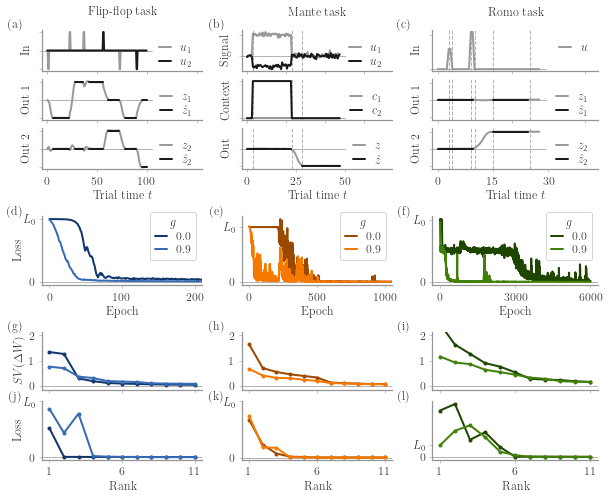

In [21]:
# Join figures
# 3x3: three tasks x (explain, svs, reconstruc loss)
fig = plt.figure(figsize=(fig_width, 1.25 * fig_height))

dx = 0.035
lefts = [dx/2, 0.33 + dx, 0.66 + dx]
rights = [0.33 - dx, 0.66 - dx, 1 - dx/2]

dy = 0.035
y1 = 0.60
y2 = 0.34
bottoms = [y1 + 2 * dy, y2 + 2*dy, dy/2]
tops = [1 - dy/2, y1 - dy, y2 - dy]

###################################################################################################
# Choose which values of g to plot
idx_sample = 3

# max_epochs = [200, 1000, 3000]
idxs_g = [0, 3]
idxs_g_all = [idxs_g]*3

max_epochs = [200, 1000, 6000]

for i in range(3):
    idxs_g = idxs_g_all[i]
    legend=True
    xlbl_on = True
    
    # Explain task
    gs0 = GridSpec(3, 1)
    gs0.update(left=lefts[i], right=rights[i], bottom=bottoms[0], top=tops[0], wspace=0.0, hspace=0.2)
    axes_explain = [plt.subplot(gs0[j, 0]) for j in range(3)]
    plot_tasks_explain[i](fig, axes_explain, tasks_explain[i], tasks_params[i], xlbl_on=xlbl_on)

    # Loss over training
    gs0 = GridSpec(1, 1)
    gs0.update(left=lefts[i], right=rights[i], bottom=bottoms[1], top=tops[1], wspace=0.0, hspace=0.0)
    ax_loss = plt.subplot(gs0[0, 0])
    plot_loss_over_training(fig, ax_loss, idx_sample, idxs_g, tasks_loss[i], legend=legend, max_epoch=max_epochs[i], 
                            xlbl_on=xlbl_on, ylbl_on=i==0, colors=cs[i])
    
    # SVs and reconstruction loss
    gs0 = GridSpec(2, 1)
    gs0.update(left=lefts[i], right=rights[i], bottom=bottoms[2], top=tops[2], wspace=0.0, hspace=0.2)
    axes_svs = [plt.subplot(gs0[j, 0]) for j in range(2)]
    plot_sv_recon_loss(fig, axes_svs, idx_sample, idxs_g, tasks_svs[i], min_rank=1, max_rank=11, 
                       xlbl_on=xlbl_on, ylbl_on=i==0, colors=cs[i])
    
# Label plots
ax_idxs = [0, 6, 12,
           3, 9, 15, 
           4, 10, 16,   
           5, 11, 17,]
for i, ax_idx in enumerate(ax_idxs):
    ax = fig.axes[ax_idx]
    ax.text(-0.17, 0.98, flbs[i], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)
for i, ax_idx in enumerate(ax_idxs[:3]):
    ax = fig.axes[ax_idx]
    ax.set_title(tasks_lbl[i] + "  task", pad=15)

style.fixticks(fig)
fig_name = "all_tasks_explain_loss"
if ML_RNN:
    fig_name += "_ML_RNN"
if train_wi or train_wo:
    fig_name += "_train_wio"
if save_fig:
    style.saving_fig(fig, figure_path, fig_name, 'pdf')
    style.saving_fig(fig, figure_path, fig_name, 'png')
plt.show(fig)
plt.close(fig)

Save figure to ../../tex/neurips_2020/submission_2/figures\all_tasks_learning_time_min_rank_train_wio.pdf
Save figure to ../../tex/neurips_2020/submission_2/figures\all_tasks_learning_time_min_rank_train_wio.png


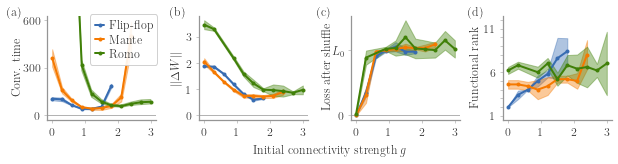

In [22]:
# Training times and minimal rank
fig = plt.figure(figsize=(fig_width, 0.3 * fig_height))
gs0 = GridSpec(1, 4)
gs0.update(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.4, hspace=0.0)
axes = [plt.subplot(gs0[0, j]) for j in range(4)]
ax0, ax1, ax2, ax3 = axes
ms = 3

min_num_samples_for_avg = 5
    
for i in range(3):
    gs, epochs, losses_all, lr = tasks_loss[i]
    gs, ranks, sv_dw_all, loss_rr_all = tasks_svs[i]
    n_gs = len(gs)
    
    # Learning time
    loss_0 = losses_all[:, :, 0]
    loss_c = rel_loss_c * loss_0
    idxs_c = np.argmax(losses_all < loss_c[:, :, None], axis=-1)
    epochs_c = epochs[idxs_c]
    
    # Norm 
    sv_dw_last = sv_dw_all[:, :, -1]
    norm_dw = np.sqrt(np.sum(sv_dw_last**2, axis=-1))
    
    # Loss after shuffling
    loss_shuff = tasks_loss_shuff[i]
    loss_0 = losses_all[:, :, 0]
    rel_loss_shuff = loss_shuff / loss_0
    
    # Minimal rank
    loss_0 = loss_rr_all[:, :, 0]
    loss_c = rel_loss_c * loss_0
    idxs_c = np.argmax(loss_rr_all < loss_c[:, :, None], axis=-1)
    ranks_c = ranks[idxs_c]
    
    # Mask
    mask_mr = ranks_c > 0
    mask_lt = epochs_c > 0
    mask = mask_lt * mask_mr
    
    # Compute mean and std
    ranks_c_m, ranks_c_s = np.zeros((2, n_gs))
    epochs_c_m, epochs_c_s = np.zeros((2, n_gs))
    rel_loss_shuff_m, rel_loss_shuff_s = np.zeros((2, n_gs))
    norm_dw_m, norm_dw_s = np.zeros((2, n_gs))
    mask_3 = np.zeros((n_gs), dtype=bool)
    for j in range(n_gs):
        if mask[:, j].sum() >= min_num_samples_for_avg:
            ranks_c_m[j] = ranks_c[:, j][mask[:, j]].mean()
            ranks_c_s[j] = ranks_c[:, j][mask[:, j]].std()
            epochs_c_m[j] = epochs_c[:, j][mask[:, j]].mean()
            epochs_c_s[j] = epochs_c[:, j][mask[:, j]].std()
            rel_loss_shuff_m[j] = rel_loss_shuff[:, j][mask[:, j]].mean()
            rel_loss_shuff_s[j] = rel_loss_shuff[:, j][mask[:, j]].std()
            norm_dw_m[j] = norm_dw[:, j][mask[:, j]].mean()
            norm_dw_s[j] = norm_dw[:, j][mask[:, j]].std()
            mask_3[j] = True
    
    # Plot
    c = colors[i]
    ax0.plot(gs[mask_3], epochs_c_m[mask_3], 'o-', lw=lw, ms=ms, c=c, label=tasks_lbl[i])
    ax1.plot(gs[mask_3], norm_dw_m[mask_3], 'o-', lw=lw, ms=ms, c=c, label=tasks_lbl[i])
    ax2.plot(gs[mask_3], rel_loss_shuff_m[mask_3], 'o-', lw=lw, ms=ms, c=c, label=tasks_lbl[i])
    ax3.plot(gs[mask_3], ranks_c_m[mask_3], 'o-', lw=lw, ms=ms, c=c, label=tasks_lbl[i])
    # Std 
    alpha=0.4
    ax0.fill_between(gs[mask_3], epochs_c_m[mask_3] - epochs_c_s[mask_3], epochs_c_m[mask_3] + epochs_c_s[mask_3], 
                     color=c, alpha=alpha)
    ax1.fill_between(gs[mask_3], norm_dw_m[mask_3] - norm_dw_s[mask_3], norm_dw_m[mask_3] + norm_dw_s[mask_3], 
                     color=c, alpha=alpha)
    ax2.fill_between(gs[mask_3], rel_loss_shuff_m[mask_3] - rel_loss_shuff_s[mask_3], rel_loss_shuff_m[mask_3] + rel_loss_shuff_s[mask_3], 
                     color=c, alpha=alpha)
    ax3.fill_between(gs[mask_3], ranks_c_m[mask_3] - ranks_c_s[mask_3], ranks_c_m[mask_3] + ranks_c_s[mask_3], 
                     color=c, alpha=alpha)
            

########################################################
ax0.axhline(0, ls='-', c='0.7', zorder=-1)
ymax = 600
ax0.set_yticks([0, ymax//2, ymax])
ax0.set_ylim(-ymax * 0.05, ymax * 1.05)

ax1.axhline(0, ls='-', c='0.7', zorder=-1)
ax1.set_yticks([0, 1, 2, 3])

ax2.axhline(0, ls='-', c='0.7', zorder=-1)
ax2.set_yticks([0, 1])
ax2.set_yticklabels([0, "$L_0$"])


ax0.set_ylabel(r"Conv. time", labelpad=0)
ax1.set_ylabel("$||\Delta W||$", labelpad=4)
ax2.set_ylabel("Loss after shuffle", labelpad=0)
ax3.set_ylabel(r"Functional rank")
for ax in fig.axes:
    ax.set_xticks([0, 1, 2, 3])
    
# ax0.legend(loc=1, ncol=1, labelspacing=0.2, handlelength=0.8, markerscale=1)
ax=ax0
leg = ax0.legend(loc=1, ncol=1, frameon=True, framealpha=0.9 ,
                 handlelength=0.8, 
                 handletextpad=0.4,
                 labelspacing=0.1, markerscale=1)
leg.get_title().set_position((-6, 0))
# Move legend down/up
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
xOffset = +0.07
bb.x0 += xOffset
bb.x1 += xOffset
yOffset = +0.07
bb.y0 += yOffset
bb.y1 += yOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

ax1.text(1.2, -0.35, "Initial connectivity strength $g$", fontsize=fs, ha='center', va='bottom', transform=ax1.transAxes)

ypos = 0.97
ax0.text(-0.3, ypos, flbs[0], fontsize=fs, ha='center', va='bottom', transform=ax0.transAxes)
ax1.text(-0.2, ypos, flbs[1], fontsize=fs, ha='center', va='bottom', transform=ax1.transAxes)
ax2.text(-0.25, ypos, flbs[2], fontsize=fs, ha='center', va='bottom', transform=ax2.transAxes)
ax3.text(-0.25, ypos, flbs[3], fontsize=fs, ha='center', va='bottom', transform=ax3.transAxes)

style.fixticks(fig)

# Ticks
min_rank = 1
max_rank = 12
yticks = np.arange(min_rank, max_rank + 1)
ax3.set_yticks(yticks)
yticklabels = []
for i in yticks:
#     if i in [1, 5, 9]:
    if i in [1, 6, 11]:
        yticklabels.append(i)
    else:
        yticklabels.append("")
ax3.set_yticklabels(yticklabels)
ax3.set_ylim(min_rank-0.5, max_rank+0.5)

fig_name = "all_tasks_learning_time_min_rank"
if ML_RNN:
    fig_name += "_ML_RNN"
if train_wi or train_wo:
    fig_name += "_train_wio"
if save_fig:
    style.saving_fig(fig, figure_path, fig_name, 'pdf')
    style.saving_fig(fig, figure_path, fig_name, 'png')
plt.show(fig)
plt.close(fig)

Save figure to ../../tex/neurips_2020/submission_2/figures\all_tasks_sv_ev_train_wio.pdf
Save figure to ../../tex/neurips_2020/submission_2/figures\all_tasks_sv_ev_train_wio.png


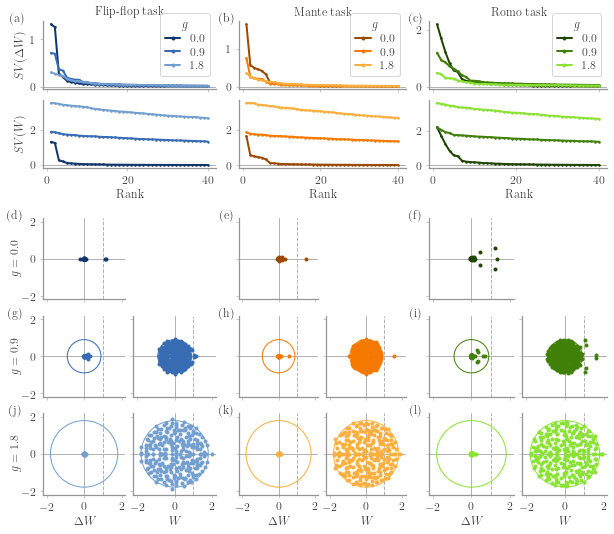

In [23]:
# Singular values of W, W_0, dW
# evs = [ev_flipflop, ev_mante, ev_romo]
# svs = [sv_flipflop, sv_mante, sv_romo]
evs = tasks_ev
svs = tasks_sv
idx_sample = 0
idxs_g_plt = np.array([0, 3, 6])
n_gp = len(idxs_g_plt)
n_tasks=3
lw=2
w_lbls = np.array([r"$W_0$", r"$W_0 + \Delta W$", r"$\Delta W$"])

# Ranks for SVs
rank_max = 40
ranks = np.arange(rank_max) + 1

# Subplot positions
dx = 0.02
lefts = [dx/2, 0.33 + dx, 0.66 + dx]
rights = [0.33 - dx, 0.66 - dx, 1 - dx/2]
dy = 0.05
y1 = 0.63
bottoms = [y1 + dy, dy/2]
tops = [1 - dy/2, y1 - dy]

fig = plt.figure(figsize=(fig_width, 1.4 * fig_height))
axes_ev_all = []
axes_sv_all = []
for i in range(n_tasks):
    
    gs0 = GridSpec(2, 1)
    gs0.update(left=lefts[i], right=rights[i], bottom=bottoms[0], top=tops[0], wspace=0.2, hspace=0.15)
    axes_sv_all.append([plt.subplot(gs0[k, 0]) for k in range(2)])

    gs0 = GridSpec(n_gp, 2)
    gs0.update(left=lefts[i], right=rights[i], bottom=bottoms[1], top=tops[1], wspace=0.1, hspace=0.2)
    axes_ev = []
    for k in range(n_gp):
        if k == 0:
            axes_ev.append([plt.subplot(gs0[k, 0])])
        else:
            axes_ev.append([plt.subplot(gs0[k, j]) for j in range(2)])
    axes_ev_all.append(axes_ev)
#     axes_ev_all.append([[plt.subplot(gs0[k, j]) for j in range(2)] for k in range(n_gp)])
axes_sv_all = np.array(axes_sv_all)
axes_ev_all = np.array(axes_ev_all)

for idx_task in range(n_tasks):
    axes_sv = axes_sv_all[idx_task]
    axes_ev = axes_ev_all[idx_task]


    max_sv = svs[idx_task][:, idx_sample, idxs_g_plt].max()
    xmax_sv = max_sv * 1.1
    
    gs, epochs, losses_all, lr = tasks_loss[idx_task]

    # SVs
    ax0, ax1 = axes_sv
    for idx_i, i in enumerate(idxs_g_plt):
        c = cs[idx_task, idx_i]
        g = gs[i]
        
        # SVs
        sv = svs[idx_task][:, idx_sample, i]
        ax0.plot(ranks, sv[2, :rank_max], '.-', lw=lw, c=c, label="%.1f" % g)
        ax1.plot(ranks, sv[1, :rank_max], '.-', lw=lw, c=c)

#     ax0.legend(loc=1, ncol=1, frameon=False, #title="$g$", title_fontsize=fs, 
#                labelspacing=0.05, handlelength=1.)
    leg = ax0.legend(loc=1, ncol=1, labelspacing=0.05, handlelength=1.3, #markerscale=1, columnspacing=0.5, handletextpad=0.3, 
               title="$g$", title_fontsize=fs,)
    ax_leg = ax0
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax_leg.transAxes)
    xOffset = 0.
    bb.x0 += xOffset
    bb.x1 += xOffset
    yOffset = 0.2
    bb.y0 += yOffset
    bb.y1 += yOffset
    leg.set_bbox_to_anchor(bb, transform = ax_leg.transAxes)

    
    for ax in [ax0, ax1, ax3]:
        ax.axhline(0, ls='-', c='0.7', zorder=-1)

    if idx_task == 0:
        ax0.set_ylabel(r"$SV(\Delta W)$")
        ax1.set_ylabel(r"$SV(W)$")
    ax1.set_xlabel(r"Rank")
    ax0.set_xticklabels([])
            
            
    # EVs
    for idx_i, i in enumerate(idxs_g_plt):
        c = cs[idx_task, idx_i]
        g = gs[i]
        
        if i == 0:
            ax2, = axes_ev[idx_i]
        else:
            ax2, ax3 = axes_ev[idx_i]
        
        ev = evs[idx_task][:, idx_sample, i]

        ms = 3
        ax2.plot(ev[2].real, ev[2].imag, 'o', ms=ms, c=c)
        if i > 0:
            ax3.plot(ev[1].real, ev[1].imag, 'o', ms=ms, c=c)

        for ax in axes_ev[idx_i]:
            circ = plt.Circle((0, 0), g, fill=False, color=c, linewidth=1, zorder=0)
            ax.add_artist(circ)
            ax.axvline(1, ls='--', c='0.7', zorder=-1)
            ax.axvline(0, ls='-', c='0.7', zorder=-1)
            ax.axhline(0, ls='-', c='0.7', zorder=-1)
            ymax = 2.2
            xmax = 2.2
            ax.set_ylim(-ymax, ymax)
            ax.set_xlim(-ymax, xmax)
            ax.set_xticks([-2, 0, 2])
            if idx_i < (n_gp - 1):
                ax.set_xticklabels([])
        if idx_task == 0:
            ax2.set_ylabel(r"$g = %.1f$" % g, labelpad=0)
        else:
            ax2.set_yticklabels([])
        if i > 0:
            ax3.set_yticklabels([])
        
        if idx_i == (n_gp - 1):
            ax2.set_xlabel(r"$\Delta W$")
            ax3.set_xlabel(r"$W$")
            
    # Task
    ax0.text(0.5, 1.05, tasks_lbl[idx_task] + "  task", fontsize=fs, ha='center', va='bottom', transform=ax0.transAxes)
            
# Label plots
# ax_idxs = [0, 1, 2, 6, 12, 18, 8, 14, 20, 10, 16, 22]
ax_idxs = [0, 8, 16, 2, 10, 18, 4, 12, 20, 6, 14, 22]
ax_idxs = [0, 7, 14, 2, 9, 16, 3, 10, 17, 5, 12, 19]
for i, ax_idx in enumerate(ax_idxs):
    if i == 0:
        xpos = -0.15
    elif i in [1, 2]:
        xpos = -0.07
    elif i % 3==0:
        xpos = -0.34
    else:
        xpos = -0.15
    ax = fig.axes[ax_idx]
    ax.text(xpos, 0.95, flbs[i], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)

style.fixticks(fig)
fig_name = "all_tasks_sv_ev"
if ML_RNN:
    fig_name += "_ML_RNN"
if train_wi or train_wo:
    fig_name += "_train_wio"
if save_fig:
    style.saving_fig(fig, figure_path, fig_name, 'pdf')
    style.saving_fig(fig, figure_path, fig_name, 'png')
plt.show(fig)
plt.close(fig)

Save figure to ../../tex/neurips_2020/submission_2/figures\flipflop_sv_ev_train_wio.pdf
Save figure to ../../tex/neurips_2020/submission_2/figures\flipflop_sv_ev_train_wio.png


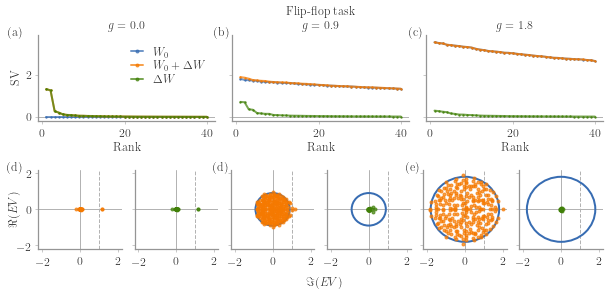

Save figure to ../../tex/neurips_2020/submission_2/figures\mante_sv_ev_train_wio.pdf
Save figure to ../../tex/neurips_2020/submission_2/figures\mante_sv_ev_train_wio.png


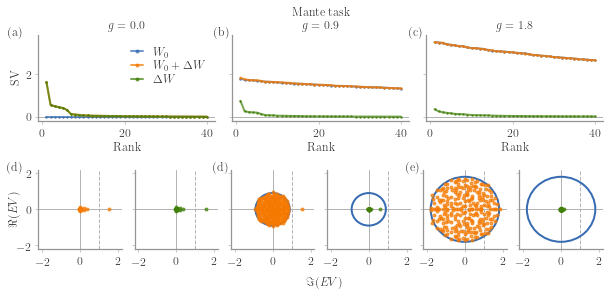

Save figure to ../../tex/neurips_2020/submission_2/figures\romo_sv_ev_train_wio.pdf
Save figure to ../../tex/neurips_2020/submission_2/figures\romo_sv_ev_train_wio.png


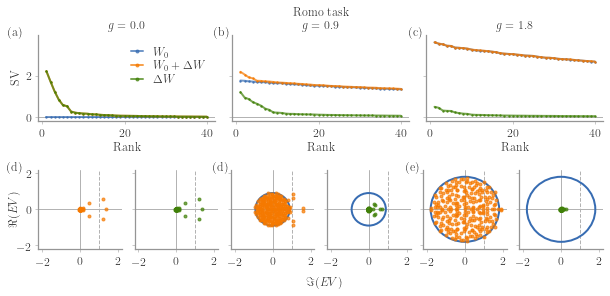

In [24]:
# Singular values of W, W_0, dW
# evs = [ev_flipflop, ev_mante, ev_romo]
# svs = [sv_flipflop, sv_mante, sv_romo]
evs = tasks_ev
svs = tasks_sv

idx_sample = 0
idxs_g_plt = np.array([0, 3, 6])
alpha = 0.7

for idx_task in range(3):

    fig = plt.figure(figsize=(8, 3.2), facecolor='w')
    axes = fig.subplots(3, 3, sharex=False)

    dy = 0.07
    y1 = 0.45
    bottoms = [y1 + 2 * dy, dy/2]
    tops = [1 - dy/2, y1 - dy]

    gs0 = GridSpec(1, 3)
    gs0.update(left=0.01, right=0.99, bottom=bottoms[0], top=tops[0], wspace=0.1, hspace=0.0)
    axes_sv = [plt.subplot(gs0[0, j]) for j in range(3)]

    gs0 = GridSpec(1, 6)
    gs0.update(left=0.01, right=0.99, bottom=bottoms[1], top=tops[1], wspace=0.15, hspace=0.0)
    axes_ev = []
    for j in range(3):
        axes_ev.append([plt.subplot(gs0[0, 2 * j + i]) for i in range(2)])

    lw=2
    w_lbls = np.array([r"$W_0$", r"$W_0 + \Delta W$", r"$\Delta W$"])

    # idx_task = 0

    max_ev_r = evs[idx_task][:, idx_sample, idxs_g_plt].real.max()
    max_ev_i = evs[idx_task][:, idx_sample, idxs_g_plt].imag.max()
    xmax = max_ev_r * 1.1
    ymax = max_ev_i * 1.2
    ymax = 2.2
    xmax = 2.2

    max_sv = svs[idx_task][:, idx_sample, idxs_g_plt].max()
    xmax_sv = max_sv * 1.1

    # Choose task
    for i in range(3):
        idx_g = idxs_g_plt[i]
    #     ax0, ax1, ax2 = axes[:, i]
        ax0 = axes_sv[i]
        ax1, ax2 = axes_ev[i]
        gs, epochs, losses_all, lr = tasks_loss[idx_task]

        g = gs[idx_g]
        ev = evs[idx_task][:, idx_sample, idx_g]
        sv = svs[idx_task][:, idx_sample, idx_g]
        # SVs
        rank_max = 40
        ranks = np.arange(rank_max) + 1
        for j, sv_j in enumerate(sv):
            ax0.plot(ranks, sv_j[:rank_max], '.-', lw=lw, c=cs[j, 1], label=w_lbls[j], alpha=alpha)
        ax0.axhline(0, ls='-', c='0.7', zorder=-1)
        ax0.set_ylim(-0.2, xmax_sv)
        if i == 0:
            ax0.legend(loc=1, ncol=1, frameon=False, #title="$g$", title_fontsize=fs, 
                       labelspacing=0.05, handlelength=1.)

        # EVs
        ms= 3
        ax1.plot(ev[1].real, ev[1].imag, 'o', ms=ms, c=cs[1, 1], alpha=alpha)
        ax2.plot(ev[2].real, ev[2].imag, 'o', ms=ms, c=cs[2, 1], alpha=alpha)

        for ax in [ax1, ax2]:
            circ = plt.Circle((0, 0), g, fill=False, color=cs[0, 1], linewidth=2, zorder=0)
            ax.add_artist(circ)
            ax.axvline(1, ls='--', c='0.7', zorder=-1)
            ax.axvline(0, ls='-', c='0.7', zorder=-1)
            ax.axhline(0, ls='-', c='0.7', zorder=-1)
            ax.set_ylim(-ymax, ymax)
            ax.set_xlim(-ymax, xmax)
            ax.set_xticks([-2, 0, 2])
        if i == 0:
            ax0.set_ylabel(r"SV")
            ax1.set_ylabel(r"$\Re (EV)$", labelpad=-4)
        else:
            for ax in [ax0, ax1, ax2]:
                ax.set_yticklabels([])
        ax2.set_yticklabels([])

        ax0.set_xlabel(r"Rank")
        ax0.set_title("$g = %.1f$" % g, pad=5)
        if i == 1:
            ax1.text(1.12, -0.5, r"$\Im (EV)$", fontsize=fs, ha='center', va='bottom', transform=ax1.transAxes)
            # Task
            ax0.text(0.5, 1.2, tasks_lbl[idx_task] + "  task", fontsize=fs, ha='center', va='bottom', transform=ax0.transAxes)
            
    # Label plots
    i=0
    ax = fig.axes[i]
    ax.text(-0.13, 0.95, flbs[i], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)
    for i in range(1, 3):
        ax = fig.axes[i]
        ax.text(-0.06, 0.95, flbs[i], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)
    i=3
    ax = fig.axes[i]
    ax.text(-0.28, 0.95, flbs[i], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)
    ax_idxs =[5, 7]
    for i, ax_idx in enumerate(ax_idxs):
        ax = fig.axes[ax_idx]
        ax.text(-0.12, 0.95, flbs[i+3], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)
            
    style.fixticks(fig)
    fig_name = tasks_name[idx_task] + "_sv_ev"
    if ML_RNN:
        fig_name += "_ML_RNN"
    if train_wi or train_wo:
        fig_name += "_train_wio"
    if save_fig:
        style.saving_fig(fig, figure_path, fig_name, 'pdf')
        style.saving_fig(fig, figure_path, fig_name, 'png')
    plt.show(fig)
    plt.close(fig)